In [1]:
import pandas as pd
import s2cell
import s2sphere
from s2sphere import CellId, LatLng, Cell
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
import numpy as np

# Load CSV into DataFrame

In [52]:
def reduce_sample_csv(max:int) ->None:
    df_sample_csv=pd.read_csv('../00-data/sample/meta_shard_0.csv')
    df_sample_csv=df_sample_csv[0:max]
    df_sample_csv.to_csv('../00-data/sample/meta_shard_0.csv',index=False)
    return df_sample_csv

def load_sample_csv(path:str) ->pd.DataFrame:
    df_sample_csv=pd.read_csv(path)
    df_sample_csv['cellid']='_'
    df_sample_csv['count']=1
    df_sample_csv['zoom']=1
    return df_sample_csv

def check_output_hashed(df:pd.DataFrame) ->None:
    print((df.cellid=='_').sum())
    return

# Make geotagging using S2 and zoom

In [53]:
def geohashing_zoom_s2(df_sample,start_zoom,end_zoom,threshold):
    df_sample_csv=df_sample.copy()
    # Initialize the df to find geohash at start and start-1 zoom
    df_sample_csv[f'geohash_{start_zoom-1}'] = df_sample_csv.apply(lambda x: s2cell.lat_lon_to_cell_id(x.lat,x.lon,start_zoom-1),axis=1)
    df_sample_csv[f'geohash_{start_zoom}'] = df_sample_csv.apply(lambda x: s2cell.lat_lon_to_cell_id(x.lat,x.lon,start_zoom),axis=1)
    completed_list=[]
    # Start looping and zooming
    for zoom in range(start_zoom-1,end_zoom):
        if (df_sample_csv.cellid=='_').sum()!=0:
            if zoom > start_zoom-1:
                print((df_sample_csv.cellid=='_').sum())
                zoom_n1 = df_sample_csv[[f'geohash_{zoom-1}','count']]
                zoom_n1=zoom_n1.groupby(by=f'geohash_{zoom-1}').count().reset_index()
                zoom_n2 = df_sample_csv[[f'geohash_{zoom}','count']]
                zoom_n2=zoom_n2.groupby(by=f'geohash_{zoom}').count().reset_index()
                for i in range(len(df_sample_csv)):
                    if (df_sample_csv[f'geohash_{zoom}'][i] in list(zoom_n2[f'geohash_{zoom}'][zoom_n2['count']<threshold]) 
                    and i not in completed_list):
                        for j in range(len(df_sample_csv)):
                            if df_sample_csv[f'geohash_{zoom}'][j]==df_sample_csv[f'geohash_{zoom}'][i]:
                                if df_sample_csv.cellid[j]=='_':
                                    df_sample_csv.loc[j,'cellid']=df_sample_csv.loc[i,f'geohash_{zoom}']
                                    df_sample_csv.loc[j,'zoom']=zoom
                                    completed_list.append(j)
                df_sample_csv.drop(columns=[f'geohash_{zoom-1}'],inplace=True)
                df_sample_csv[f'geohash_{zoom+1}'] = df_sample_csv.apply(lambda x: s2cell.lat_lon_to_cell_id(x.lat,x.lon,zoom+1),axis=1)
            else:
                next
    for k in range(len(df_sample_csv)):
        if df_sample_csv.cellid[k]=='_':
            df_sample_csv.cellid[k]=df_sample_csv[f'geohash_{zoom+1}'][k]
    df_sample_csv.drop(columns=[f'geohash_{zoom}',f'geohash_{zoom+1}'],inplace=True)
    return df_sample_csv

In [54]:
start_zoom = 5
end_zoom = 16
threshold = 20
path = '../00-data/data_csv/meta_shard_0.csv'

df_sample_csv = load_sample_csv(path)
# df_sample_csv = df_sample_csv[0:1500]
df_sample_csv_hashed = geohashing_zoom_s2(df_sample_csv,start_zoom,end_zoom,threshold)
# df_sample_csv_final.drop(columns=['geohash_6','geohash_7'],inplace=True)
# df_sample_csv['zoom'].value_counts()

4708
4669
4276
3376
2278
1754
1429
1154
796
357
88


In [59]:
# (df_sample_csv_hashed.cellid=='_').sum()
df_sample_csv

,img,lat,lon,data,cellid,count,zoom
0,a6_c4_3038144879.jpg,48.857599,2.337684,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
1,a7_00_2633379373.jpg,45.875802,0.175330,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
2,03_2e_4493999629.jpg,50.940437,6.870537,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
3,c6_12_3073882997.jpg,51.493608,7.451820,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
4,0d_1d_3586372001.jpg,43.909642,5.197563,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
...,...,...,...,...,...,...,...
4703,ac_a1_4171737184.jpg,51.635791,-0.106115,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
4704,07_a4_4360452150.jpg,49.076782,2.179498,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
4705,78_76_3676267394.jpg,51.910622,4.473302,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1
4706,34_6c_6424789109.jpg,44.755144,5.332853,ffd8ffe000104a46494600010100000100010000ffdb00...,_,1,1


In [70]:
def create_df_squares(df_sample_csv):
    # Create cellid with only the list of Cellid present in the df
    df_cellid=df_sample_csv[['cellid','count']].copy()
    df_cellid=df_cellid.groupby('cellid').sum()
    df_cellid.reset_index(inplace=True)
    # Create the columns
    df_cellid['top_left_lat'] = '_'
    df_cellid['top_left_lon'] = '_'
    df_cellid['top_right_lat'] = '_'
    df_cellid['top_right_lon'] = '_'
    df_cellid['bot_left_lat'] = '_'
    df_cellid['bot_left_lon'] = '_'
    df_cellid['bot_right_lat'] = '_'
    df_cellid['bot_right_lon']= '_'
    # Access to the Lat and Lng of each square for plot
    for i in range(len(df_cellid)):
        df_cellid.loc[i, 'top_left_lat'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(0)))[8:]
        df_cellid.loc[i,'top_left_lon'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(0)))[8:]
        df_cellid.loc[i,'top_right_lat'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(1)))[8:]
        df_cellid.loc[i,'top_right_lon'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(1)))[8:]
        df_cellid.loc[i,'bot_left_lat'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(2)))[8:]
        df_cellid.loc[i,'bot_left_lon'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(2)))[8:]
        df_cellid.loc[i,'bot_right_lat'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(3)))[8:]
        df_cellid.loc[i,'bot_right_lon'] = str(LatLng.from_point(Cell(CellId(int(df_cellid.cellid[i]))).get_vertex(3)))[8:]
    # Convert the lat and lng in a list and then extract only lat or only lng
    for i in range(len(df_cellid)):
        df_cellid.loc[i,'top_left_lat'] = [float(j) for j in df_cellid['top_left_lat'][i].split(',')][0]
        df_cellid.loc[i,'top_left_lon'] = [float(j) for j in df_cellid['top_left_lon'][i].split(',')][1] 
        df_cellid.loc[i,'top_right_lat'] = [float(j) for j in df_cellid['top_right_lat'][i].split(',')][0] 
        df_cellid.loc[i,'top_right_lon'] = [float(j) for j in df_cellid['top_right_lon'][i].split(',')][1] 
        df_cellid.loc[i,'bot_left_lat'] = [float(j) for j in df_cellid['bot_left_lat'][i].split(',')][0] 
        df_cellid.loc[i,'bot_left_lon'] = [float(j) for j in df_cellid['bot_left_lon'][i].split(',')][1] 
        df_cellid.loc[i,'bot_right_lat'] = [float(j) for j in df_cellid['bot_right_lat'][i].split(',')][0] 
        df_cellid.loc[i,'bot_right_lon'] = [float(j) for j in df_cellid['bot_right_lon'][i].split(',')][1]
    return df_cellid

In [71]:
df_cellid=create_df_squares(df_sample_csv_hashed)

df_cellid['top_left_lon'][i],df_cellid['top_right_lon'][i],df_cellid['bot_left_lon'][i],df_cellid['bot_right_lon'][i],df_cellid['bot_left_lon'][i]
df_cellid['top_left_lon'][i],df_cellid['top_left_lon'][i],df_cellid['bot_right_lon'][i],df_cellid['bot_right_lon'][i],df_cellid['bot_right_lon'][i]

df_cellid['top_left_lat'][i],df_cellid['top_right_lat'][i],df_cellid['bot_left_lat'][i],df_cellid['bot_right_lon'][i],df_cellid['bot_left_lon'][i]

In [72]:
def plot_squares(df_cellid):
    fig = plt.Figure()
    map = Basemap(projection='cyl', resolution = 'i', llcrnrlon=-5, \
                llcrnrlat=42, urcrnrlon=10, urcrnrlat=52)
    map.drawcoastlines()
    map.drawcountries()
    map.bluemarble()

    for i in range(len(df_cellid)):
        x_big = [df_cellid['top_left_lon'][i],df_cellid['top_right_lon'][i],df_cellid['bot_left_lon'][i],df_cellid['bot_right_lon'][i],df_cellid['top_left_lon'][i]]  # lon
        y_big = [df_cellid['top_left_lat'][i],df_cellid['top_right_lat'][i],df_cellid['bot_left_lat'][i],df_cellid['bot_right_lat'][i],df_cellid['top_left_lat'][i]]   # lat
        map.plot(x_big, y_big, color='yellow', lw=1)
    
    plt.show()
    
    return

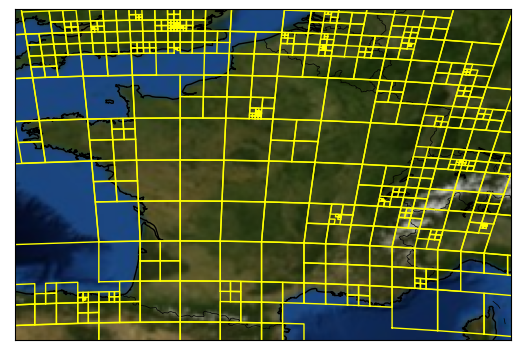

In [73]:
plot_squares(df_cellid)


In [ ]:
df_cellid

# Geohashing the map and merging

-5 et 10 en longitude
42 et 52 en latitude

In [5]:
df_sample_csv=load_sample_csv()

In [45]:
increment = 0.01
lat_start = 42
lat_end = 52
lon_start = -5
lon_end = 10
threshold = 5
lon = lon_start
lat = lat_start
x = 0
y = 0

In [ ]:
while lon<lon_end:
    while lat<lat_end:
        index=f'{x}_{y}_'
        if len(df_sample_csv[(df_sample_csv.lat>lat) & 
                         (df_sample_csv.lat<lat+increment) & 
                         (df_sample_csv.lon>lon) & 
                         (df_sample_csv.lon<lon+increment)])<threshold:
            x+=1
            lon+=increment
            index=index+f'{x}_{y}'
            if len(df_sample_csv[(df_sample_csv.lat>lat) & 
                         (df_sample_csv.lat<lat+increment) & 
                         (df_sample_csv.lon>lon) & 
                         (df_sample_csv.lon<lon+increment)])<threshold:
                y+=1
                lat+=increment
                index=index+f'{x}_{y}'
                
                

In [31]:
increment=1

In [20]:
df_sample_csv[(df_sample_csv.lat>lat_start) & (df_sample_csv.lat<lat_start+increment) & (df_sample_csv.lon>lon_start) & (df_sample_csv.lon<lon_start+increment)]

,img,lat,lon,data,cellid,count


In [ ]:
df_sample_csv[(df_sample_csv.lat>lat_start) & (df_sample_csv.lat<lat_start+2*increment) & (df_sample_csv.lon>lon_start) & (df_sample_csv.lon<lon_start+increment)]

,img,lat,lon,data,cellid,count


In [44]:
len(df_sample_csv[(df_sample_csv.lat>lat_start) & (df_sample_csv.lat<lat_start+2*increment) & (df_sample_csv.lon>lon_start) & (df_sample_csv.lon<lon_start+2*increment)])

2